# Topic Modeling for Covid-19 & China Corpus - AI for People

In this notebook we are going to use a topic modeling strategy called [Latent Dirichlet Allocation](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf). If you want to understand LDA properly we can recommend the following links:
 - [Youtube Explainer](https://www.youtube.com/watch?v=3mHy4OSyRf0)
 - [Tutorial in Python](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)
 - [Intuitive Guide to Latent Dirichlet Allocation](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158)
 
This topic modeling will be the standard LDA approach using the Gensim library. Although, there are many other packages available (NLTK, Scikit etc.) we have chosen Gensim here and we provide a bit of an intuition when it comes to a more fine-grained setting of the LDA.

### Statistical Inference (Variational Bayes vs. Gibbs Sampling)
Learning the various distributions in our corpus (the set of topics, their associated word probabilities, the topic of each word) is a problem of statistical inference. There are different ways of doing this statistical inference. The original [Latent Dirichlet Allocation](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) uses a variational Bayes approximation of the posterior distribution. What is variational Bayes then? As far as we are concerned [variational Bayesian methods](https://en.wikipedia.org/wiki/Variational_Bayesian_methods) are a family of techniques for approximating intractable integrals arising during the training of our LDA model. A different method of doing the statistical inference is [Gibbs Sampling](https://en.wikipedia.org/wiki/Gibbs_sampling). It [has been argued that Gibbs Sampling is more suitable](http://www.jmlr.org/papers/volume18/16-374/16-374.pdf) for the task of LDA.

Make sure that whatever LDA package you are using, to check what kind of statistical inference is used within its training. For Gensim, we can check the documentation: https://radimrehurek.com/gensim/models/ldamodel.html and realize "The core estimation code is based on the onlineldavb.py script, by Hoffman, Blei, Bach: Online Learning for Latent Dirichlet Allocation, NIPS 2010.", which is using Online Variational Bayes. In order to use Gibbs Sampling instead, we can use the Mallet package that provides a method called LdaMallet - which is using our Gibbs Sampling: https://radimrehurek.com/gensim/models/wrappers/ldamallet.html as it states "This module allows both LDA model estimation from a training corpus and inference of topic distribution on new, unseen documents, using an (optimized version of) collapsed gibbs sampling from MALLET."

### Package Environment
This notebook is created using Python 3.6 with a few libraries. Mainly, we are using the Gensim library (pip install Gensim), the Mallet wrapper (for the Gibbs Sampling) and a few others. Therefore, the next cells contains all the necessary libraries so you can make sure everything is installed on your system. You will need to change your system variables for the mallet environment path. [See how to install mallet here.](https://www.tutorialspoint.com/gensim/gensim_creating_lda_mallet_model.htm)

In [64]:
# importing all libraries
import os
import gensim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle
import pyLDAvis.gensim
from wordcloud import WordCloud
from IPython.display import HTML
from nltk.tokenize import TweetTokenizer
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
os.environ['MALLET_HOME'] = 'C:\\Python36-32\\mallet-2.0.8'
mallet_path = 'C:\\Python36-32\\mallet-2.0.8\\bin\\mallet' 

### Loading the corpus
Due to the Twitter restrictions of data sharing, we cannot provide the corpus. What we can provide are the Tweet-IDs from our corpus. Those can be combined with Software such as [Hydrator](https://github.com/DocNow/hydrator) to collect the corpus. We have explained in the [Technical Article II](https://medium.com/ai-for-people/the-rise-of-sinophobia-on-twitter-during-the-covid-19-pandemic-technical-part-2-384917ddd16d) how the subcorpus of tweets containing CHINA or CHINESE has been created. For this notebook it is important to note that the format of each line in the corpus is the following:
`YYYY-MM-DD HH:MM:SS ::: TWEET`
Therefore, we can split the whole line with with spaces and collect only the tweet with indexing [3:]. If the formatting of your own corpus is different, you might need to adjust these.'

In [37]:
# Loading dataset
documents = []
with open("../data/chinese_covid_copus.txt", "r", encoding="utf-8") as f_in:
    # read all lines from one batch
    document = f_in.readlines()
    # connect all lines to one big line per batch
    for tweet in document:
        # split the tweet into separate words
        tweet = tweet.split(" ")
        # get rid of empty entries
        tweet = [word.strip(",").strip("\n").strip(".").lower() for word in tweet if word]
        # append the batch words in the documents list
        tweet = tweet[3:]
        documents.append(tweet)

print("Tweets read: "+str(len(documents)))

Tweets read: 16724


### Pre-Processing 
Next, we will define two functions that will help us with the pre-processing of the data. For the LDA, we need to tokenize all words in our corpus. On Twitter, language has a bit of a different "slang" and hence we want our pre-processing to account for specific Twitter slang. In our first processing part, we are simply loading a list of stopwords. You can simply create a text file and store words in there, which you want to filter out. We have used some list found [here](https://github.com/meetsha/gensim/blob/master/stopwords.txt) and [here](https://gist.github.com/sebleier/554280). Now we define Gensim's simple preprocessing, which lowercases, tokenizes our words. We also don't want to allow tokens smaller than 3 items (e.g. "aa", "fu", "lo" "gg" etc).

Note: We already know at least 2 topics of the corpus: China/Chinese and Covid-19. Therefore, if we want to explore more topics and do not want the already known topics to influence our topic modeling, we add those terms to the stopwords manually.

In [38]:
# loading the stopwords
with open("../data/stopwords.txt", "r") as f_in:
    stopwords = f_in.readlines()
    stopwords = [word.strip() for word in stopwords]
    stopwords = set(stopwords)
    
    stopwords.update(["china","chinese","covid19", "coronavirus", "ncov2019",
                      "2019nco", "ncov", "ncov2019", "2019ncov", "covid", "covid-", "covid_"])

def preprocess(word_list):
    result = []
    text = " ".join(word_list)
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stopwords:
            result.append(token)
    return result

### Tweet Tokenization
We are also using the NLTK package now, because it contains a tokenizer that can handle tweets more appropriately. Meaning, it has more-fine grained tokenization for Twitter slang. [Find out more in the documentation of its source code](https://www.nltk.org/_modules/nltk/tokenize/casual.html#TweetTokenizer).

In [39]:
# Tokenization 
print("Tweet tokenization...")
tweet_tokenizer = TweetTokenizer()
tweet_token_docs = []
for idx, document in enumerate(documents):
    document = " ".join(document)
    tweet_token_docs.append(tweet_tokenizer.tokenize(document))
print("... finished.")

Tweet tokenization...
... finished.


### Creating a Bag-of-Words and Dictionary
We now have to transform our tokens into bag of words in order to use the Gensim LDA. For a more detailed and general explanation of this, [see here](https://www.tutorialspoint.com/gensim/gensim_creating_a_bag_of_words_corpus.htm). 

In [40]:
print("Preprocessing...")
processed_docs = [preprocess(elem) for elem in tweet_token_docs]
dictionary = gensim.corpora.Dictionary(processed_docs)
del_ids = [k for k,v in dictionary.items() if v=='https']
dictionary.filter_tokens(bad_ids=del_ids)
print("... finished.")
# turn documents in bags of words
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# storing dictionary - we will later see why
pickle.dump(dictionary,open("../data/dictionary.pkl","wb"))

Preprocessing...
... finished.


### Training the LDA model (using Gibbs Sampling)
We can now train our LDA model provided the bag-of-words and dictionary of tf-idf-terms we have created. Topic Modeling algorithms are trying to find topics within a given corpora. Naturally, a corpus of text does not have a pre-defined set of N topics. Therefore, we need to decide how many topics we want the LDA model to form/find within our corpus. It is a good idea to start with 1 topic and work our way up to 16 topics. In the next cell, we are running 16 trainings with an increaing topic size and store each model in `mallet_models`. Additionally, after every model is created we assess it's coherence value. [Here](https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/) is an article that explains this a bit more. In very short, our coherence value is a measure of the statistical coherence within the topics. Or to put it in practical terms: the better our coherence score for a given topic size, the better. Note: there are diffenent coherence measures and we have chosen the $C_v$ measure. It is not as fast as $C_{Mass}$, but considered more thorough - if you want to learn [more about this topic, check this article](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf). We store the evaluation of the $C_V$ in a list for all 16 topic sizes.

In [6]:

mallet_models_coherence_cV = []
mallet_models = dict()

for num_topics in range(1, 17):
    print("Type: Mallet | Topics: "+str(num_topics))
    model_mallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=bow_corpus, 
                                             num_topics=num_topics,id2word=dictionary, workers=4)
    
    coherencemodel = CoherenceModel(model=model_mallet, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_value = coherencemodel.get_coherence()
    mallet_models_coherence_cV.append(coherence_value)
    
    mallet_models[num_topics] = model_mallet
    

Type: Mallet | Topics: 1
Type: Mallet | Topics: 2
Type: Mallet | Topics: 3
Type: Mallet | Topics: 4
Type: Mallet | Topics: 5
Type: Mallet | Topics: 6
Type: Mallet | Topics: 7
Type: Mallet | Topics: 8
Type: Mallet | Topics: 9
Type: Mallet | Topics: 10
Type: Mallet | Topics: 11
Type: Mallet | Topics: 12
Type: Mallet | Topics: 13
Type: Mallet | Topics: 14
Type: Mallet | Topics: 15
Type: Mallet | Topics: 16


### Visualizing the Coherence
After training we can now plot the coherence for each topic size in order to identify the best topic size for further analysis. For this, we can use the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_\(clustering\)). To understand this method, we assume that our coherence value will roughly follow a saturation curve. That is, it will quickly increase with increasing topic size, but then also quickly converge towards a certain value despite ever rising topic size. That would mean, we could simply pick a very large topic number e.g. 100 topics in order to receive a high coherence value. But it simply means that our model is more confident in sorting words from the corpus in smaller topics (few topics = large topics). At the very end, if every word would get there own topic, we'd have a perfect coherence within those topics, yet we would have not gained any "topics" anymore and would end up on a word level again. Therefore, we need to find the spot at which we have an useful topic size with a reasonable coherence (the elbow in the curve).

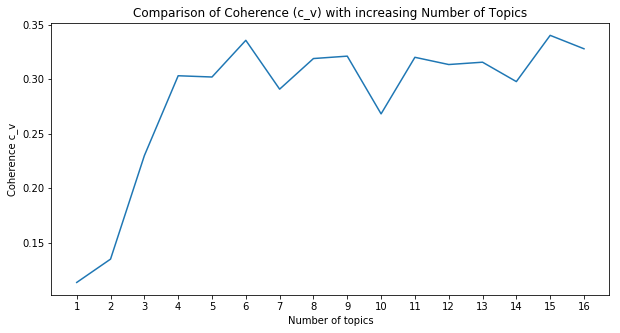

In [7]:
fig = plt.figure(figsize=[10,5])
ax = plt.axes()

ax.plot(range(1, len(mallet_models)+1),  mallet_models_coherence_cV)
plt.title("Comparison of Coherence (c_v) with increasing Number of Topics")
plt.xlabel("Number of topics")
plt.ylabel("Coherence c_v")
plt.xticks(range(1,17))
plt.show()

print()

### Storing the relevant models
If we look at the plot above we can see the first increase of coherence stop at topic size 4. We can also observe a peak at topic size 6 and a trend of slight increasing coherence up until 16 topics. We now do two technical tricks to work with those selected models further. As LDA is a statistical learning method that includes randomness in both the learning and inference steps, the resulting models that you will produce will **always** be slightly different. We can see this, as an early version of this code also indicated topic 4 and 6 to be interesting, but 16 had a slightly higher peak than 15. Your own results will be slightly different altogether. Yet, they should always show a very similar curve! 

In order to work with the exact same models and in order to save time when re-running this code at a later point, we are now firstly going to transform the mallet models into LDA models (this is just a technicality to use the standard tools for this model despite it being from a foreign package, namely mallet). We simply call the `malletmodel2ldamodel` function to do this. Secondly, we are going to store the models on our hard-drive using python's in-built archive manager pickle. With `pickle.dump` and `pickle.load` we can store and load any file.

In [16]:
# Turning mallet model to gensim model for plotting
model_4 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_models[4])
model_6 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_models[6])
model_16 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_models[16])

# Storing the relevant models
pickle.dump(model_4,open('../models/lda_4.pkl','wb'))
pickle.dump(model_6,open('../models/lda_6.pkl','wb'))
pickle.dump(model_16,open('../models/lda_16.pkl','wb'))

### Loading the relevant models
You can run the notebook from here after you have trained and stored your models without having to re-run the entire training etc. You can also load the models we have provided if you have failed to create them yourself or haven't had the time to get your corpus ready. **Remember**: You always need to run the very first cell with the library imports for this loading to work.

In [2]:
# Loading the relevant models
print("Opening LDA model.")
with open('../models/lda_4.pkl', 'rb') as f:
    model_4 = pickle.load(f)

print("Opening LDA model.")
with open('../models/lda_6.pkl', 'rb') as f:
    model_6 = pickle.load(f)
    
print("Opening LDA model.")
with open('../models/lda_16.pkl', 'rb') as f:
    model_16 = pickle.load(f)

Opening LDA model.
Opening LDA model.
Opening LDA model.


### First look at topics
We can now investigate our models. The first naive way to do this, is to use the `print_topics` function from the LDA model. We can specify the number of words from each topic that we'd like to investigate. In the cell below, we ask for 8 words from each topic. Each word comes with a weight/importance value for that topic. The topics are for now just labeled 0, 1, 2 and so forth. It is our task to come up with an interpretation of the provided topics, according to the words suggested for them.

In [5]:
for idx, topic in model_4.print_topics(num_words=8):
    print('Topic: {} \nWords: {}'.format(idx, topic))
print("-----------------------")
for idx, topic in model_6.print_topics(num_words=8):
    print('Topic: {} \nWords: {}'.format(idx, topic))
print("-----------------------")
for idx, topic in model_16.print_topics(num_words=8):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.043*"world" + 0.025*"pandemic" + 0.014*"time" + 0.011*"human" + 0.010*"stop" + 0.009*"health" + 0.007*"global" + 0.006*"started"
Topic: 1 
Words: 0.037*"trump" + 0.030*"realdonaldtrump" + 0.010*"outbreak" + 0.009*"president" + 0.008*"america" + 0.008*"blame" + 0.008*"media" + 0.007*"american"
Topic: 2 
Words: 0.042*"virus" + 0.027*"chinesevirus" + 0.020*"chinavirus" + 0.013*"government" + 0.011*"covidー" + 0.011*"corona" + 0.011*"wuhanvirus" + 0.010*"news"
Topic: 3 
Words: 0.030*"cases" + 0.017*"italy" + 0.015*"deaths" + 0.015*"country" + 0.011*"countries" + 0.008*"death" + 0.008*"masks" + 0.008*"numbers"
-----------------------
Topic: 0 
Words: 0.017*"countries" + 0.015*"outbreak" + 0.012*"masks" + 0.011*"india" + 0.010*"medical" + 0.009*"spain" + 0.008*"data" + 0.008*"crisis"
Topic: 1 
Words: 0.045*"cases" + 0.023*"deaths" + 0.022*"world" + 0.022*"country" + 0.022*"italy" + 0.012*"death" + 0.011*"numbers" + 0.011*"number"
Topic: 2 
Words: 0.042*"world" + 0.040*"pand

### Visualization I: Wordclouds
The results above are rather hard to interpret and we will now look at a way of visualizing those topics. One method is a very simple wordcloud. Fortunately, there is a python package for doing exactly those. In the cell below, we are generating 4 word clouds for our 4 topic model. There are a lot of parameters e.g. colors, size, orientation, dimension etc. which are all purely cosmetical and you can look at the documentation of the Wordcloud package to try and adjust/understand them. It just essential to note that the presented wordclouds are generated taking the frequency (`generate_from_frequencies`), which means that the bigger a word in the cloud, the more important it is for the topic.

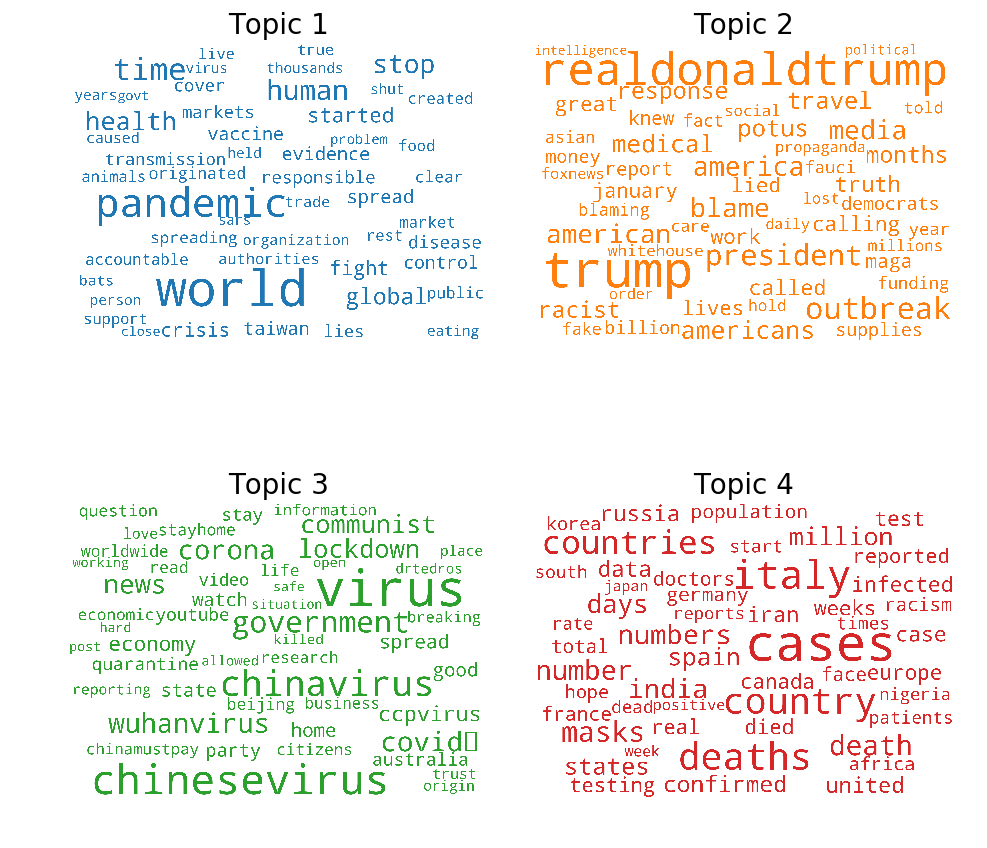

In [24]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=gensim.parsing.preprocessing.STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=50,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = model_4.show_topics(num_topics=4, num_words=50, formatted=False)
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True, dpi=125)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

The 4 topics above already indicate some meaningful results. If you run the code with our models, you will see the same clouds here. If you have created your own models, the order and exact words in the clouds might be different. In our case, we can see the following topics:
 - Topic 1: **General, global terms** such as world, pandemic, human, health, time, global etc.
 - Topic 2: **American politics** such as trump (his twitter handle), president, potus, america, fauci etc.
 - Topic 3: **Virus** terms such as chinesevirus, chinavirus, ccpvirus, wuhanvirus, corona etc.
 - Topic 4: **Nationalities** such as countries, country, india, spain, italy, france, russia, korea, africa etc.
 
Of course, our interpretation is in itself a topic clustering as we are looking at selected words from those topics. We basically infere a topic ourselves, this is fine because we only look at 4 topics even though there might be many more topics within those. We should therefore be careful not to stop our observation here or call those 4 topics definite. Therefore, the next cell evaluates all 16 topics. We are only looking at the 15 most important words from each topic though in order to have fewer information, we also have to use a black background to make the colors more visible, again this is all cosmetics, we do not change the topics with this.

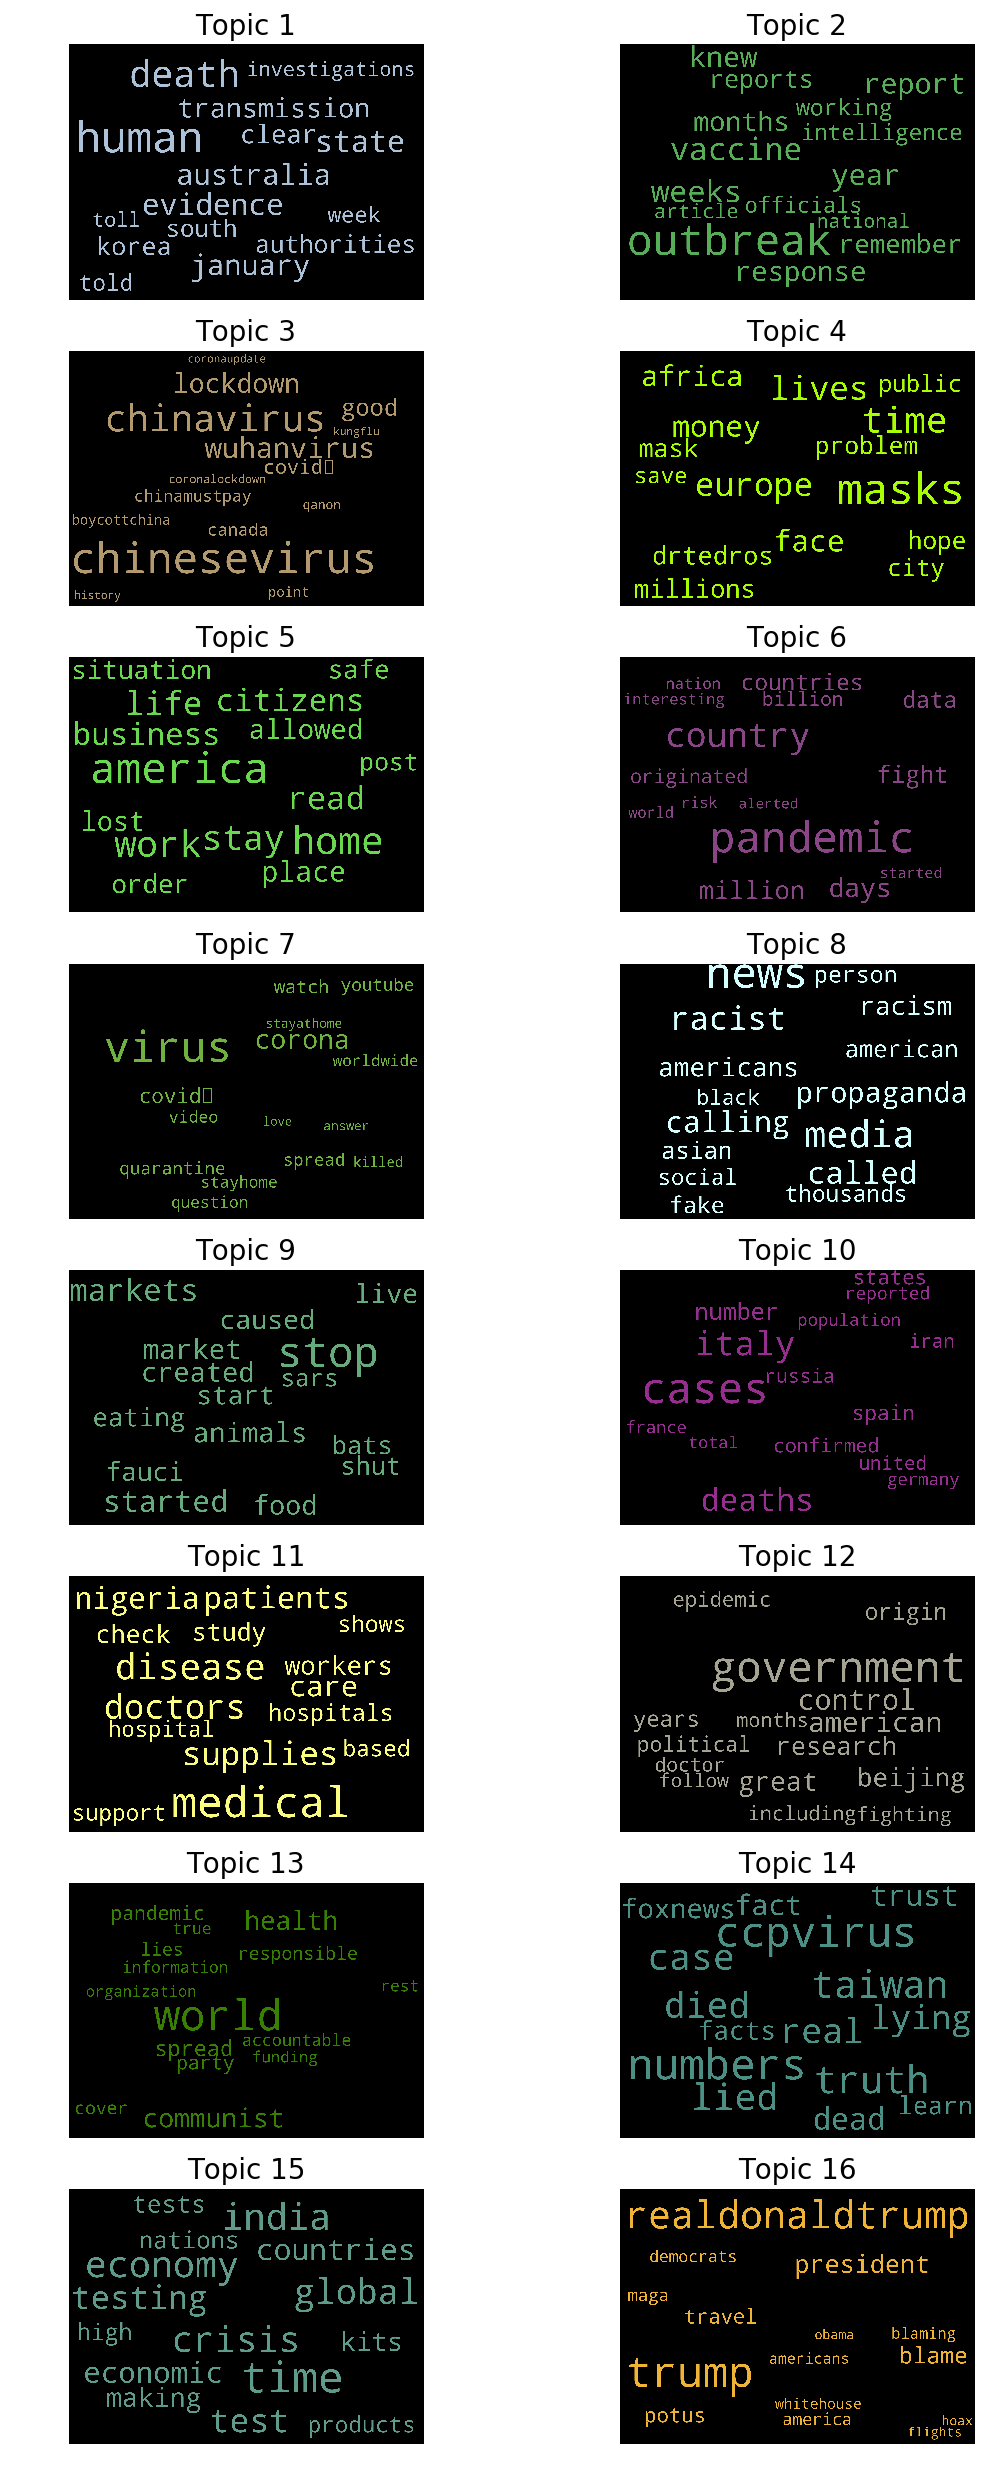

In [32]:
cols = [color for name, color in mcolors.XKCD_COLORS.items()] 

cloud = WordCloud(stopwords=gensim.parsing.preprocessing.STOPWORDS,
                  background_color='black',
                  width=2500,
                  height=1800,
                  max_words=50,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = model_16.show_topics(num_topics=16, num_words=15, formatted=False)
fig, axes = plt.subplots(8, 2, figsize=(10, 20), sharex=True, sharey=True, dpi=125)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Now that we can visualize the 16 topics, we can see some redundancy and some topics that do not really seem to fit together. The issue here is that there is no ground truth of N number of topics in our data, but we can only look at a chosen group size and see if there are meaningful topics. Some smaller clusters of words might only become apparent when we look at a lot of clusters, some only emerge when we look at very few. Let us try to find meaning for some of the 16 topics that are relevant for an investigation of for example sinophobia:

 - Topic 3: **Chinavirus** terms that relate the virus directly to Chinese with e.g. Wuhanvirus, Chinamustpay, Kungflu, Chinesevirus
 - Topic 8: **Racsim** as a topic with words such as racist, propaganda, americans and racism.
 - Topic 9: **Origin of Virus** with words such as markets, started, market, animals, created, food
 - Topic 14: **Disinformation** with term such as numbers, ccpvirus, truth, lied, died and real
 - Topic 16: **Trump** 
 
Again, we infere these topics by looking at selected words with the highest importance for each topic.

### Visualization II: pyLDAvis
In order to investigate the correlations between our topics even further, we can also use another visualization tool. Where wordcloud was rather intuitive to understand (word frequencies are mapped on size of words in clouds), we can look at pyLDAvis, which is a bit more complex but also a lot more informative. You can learn more about the [algorthms behind LDAvis in their paper](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf). You can look at the code for the package in their [git repository](https://github.com/bmabey/pyLDAvis). The next cell uses pyLDAvis to create the visualization, but **careful** as this is rather computationally expensive and might take a lot of time. As you do not want to run this more than once, we are saving the result in an html file.

In [ ]:
print("Building visualization.")
p = pyLDAvis.gensim.prepare(model_4, bow_corpus, dictionary, mds='mmds')
pyLDAvis.save_html(p, '../models/lda_4.html')

print("Building visualization.")
p = pyLDAvis.gensim.prepare(model_16, bow_corpus, dictionary, mds='mmds')
pyLDAvis.save_html(p, '../models/lda_16.html')

We can now load the html file and display it in the jupyter notebook. If you fail to create the html yourself, you can run the next cell and load the models that we provide in this repository. Unfortunately, you cannot see the result in the github view. But we can add a link to the html files on the git that renders them in html.
 - [to view the 4 topic html rendering on github click here.](https://htmlpreview.github.io/?https://github.com/aiforpeople-git/Covid19China_TopicModeling/blob/master/models/lda_4.html)
 - [to view the 16 topic html rendering on github click here.](https://htmlpreview.github.io/?https://github.com/aiforpeople-git/Covid19China_TopicModeling/blob/master/models/lda_16.html)

In [19]:
HTML(filename='../models/lda_4.html')

In [20]:
HTML(filename='../models/lda_16.html')

### Infering topic for new data
In the above visualization we can identify the distributions of words within the topics more graphically. Sliding over individual terms on the right side of the graph, we can also see to what extent each word can be found in each topic. This is a good starting point for any further analysis of terms. Let say we want to investigate which of these topics can be linked to sinophiobia for example. Here, we can now make use of the LDA model. The model can provide a statistical inference for new terms and can return a probability for each word to belong to a topic. To do this, we also need the dictionary from our original corpus. Luckily, we have saved this dictionary in `../data/dictionary.pkl` and can just load it again.
In the next cell, we will have a look at an example:

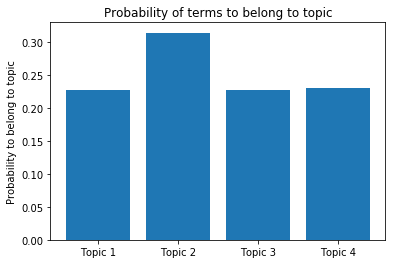

In [71]:
# loading our initial dictionary
with open('../data/dictionary.pkl', 'rb') as f:
    dictionary = pickle.load(f)

# Create a new corpus, made of previously unseen documents.
other_texts = [['trump','usa','potus','america','president','american']]

other_corpus = [dictionary.doc2bow(text) for text in other_texts]
unseen_doc = other_corpus[0]
vector = model_4[unseen_doc]  # get topic probability distribution for a document

x = [vec[0] for vec in vector]
y = [vec[1] for vec in vector]

plt.bar(x,y)
plt.xticks([0,1,2,3],["Topic 1","Topic 2","Topic 3","Topic 4"])
plt.ylabel("Probability to belong to topic")
plt.title("Probability of terms to belong to topic")
plt.show()

We can observe that the probability of our terms to belong to any of the four topics is almost equal, except for topic 2. We previously identified topic 2 to be about **American politics** and our terms are Trump, USA, potus, America, President and American. This seems to confirm our previous intuition.

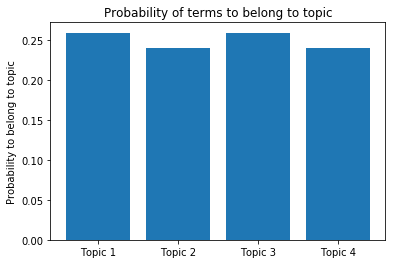

In [77]:
# loading our initial dictionary
with open('../data/dictionary.pkl', 'rb') as f:
    dictionary = pickle.load(f)

# Create a new corpus, made of previously unseen documents.
sinophobic_terms = [["chink", "bugland", "chankoro", "chinazi", "gook", "insectoid", "bugmen", "chingchong"]]

other_corpus = [dictionary.doc2bow(text) for text in sinophobic_terms]
unseen_doc = other_corpus[0]
vector = model_4[unseen_doc]  # get topic probability distribution for a document

x = [vec[0] for vec in vector]
y = [vec[1] for vec in vector]

plt.bar(x,y)
plt.xticks([0,1,2,3],["Topic 1","Topic 2","Topic 3","Topic 4"])
plt.ylabel("Probability to belong to topic")
plt.title("Probability of terms to belong to topic")
plt.show()

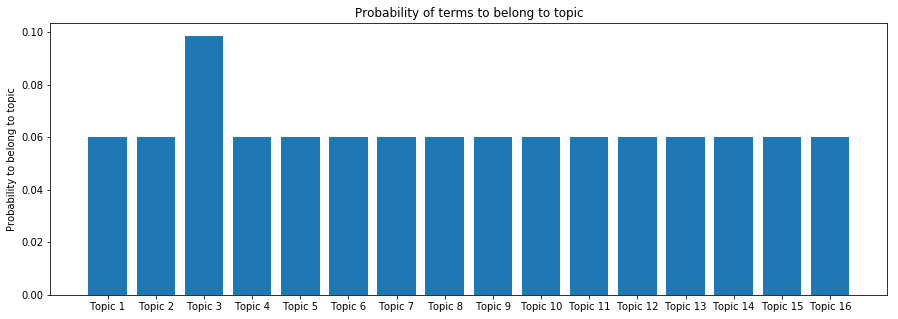

In [82]:
# loading our initial dictionary
with open('../data/dictionary.pkl', 'rb') as f:
    dictionary = pickle.load(f)

# Create a new corpus, made of previously unseen documents.
sinophobic_terms = [["chink", "bugland", "chankoro", "chinazi", "gook", "insectoid", "bugmen", "chingchong"]]

other_corpus = [dictionary.doc2bow(text) for text in sinophobic_terms]
unseen_doc = other_corpus[0]
vector = model_16[unseen_doc]  # get topic probability distribution for a document

x = [vec[0] for vec in vector]
y = [vec[1] for vec in vector]

plt.figure(figsize=[15,5])
plt.bar(x,y)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],["Topic 1","Topic 2","Topic 3","Topic 4","Topic 5","Topic 6",
                                                    "Topic 7","Topic 8","Topic 9","Topic 10","Topic 11","Topic 12",
                                                   "Topic 13","Topic 14","Topic 15","Topic 16"])

plt.ylabel("Probability to belong to topic")
plt.title("Probability of terms to belong to topic")
plt.show()